In [1]:
from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

20-Oct-22 00:33:13 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
df = pd.read_parquet("s3://allencell-hipsc-cytodata/hackathon_manifest_17oct2022.parquet")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 77


In [3]:
#From Chapter 5
#loading library, making path for 
from serotiny.transforms.dataframe.transforms import split_dataframe
Path("/home/aicsuser/serotiny_data/").mkdir(parents=True, exist_ok=True)

# Sample n cells per group
n = 2000 # number of cells per mitotic class
cells_to_include=[]
for name, group in df.groupby('cell_stage'):    
    sampled_group = group.sample(min([n,len(group)]))
    cells_to_include.append(sampled_group)
df_mitocells = pd.concat(cells_to_include).reset_index(drop=True)

# Discarding all the M6M7_single cells
df_mitocells = df_mitocells.drop(df_mitocells[df_mitocells['cell_stage']=='M6M7_single'].index)

df_mitocells['cell_stage_encoded'] = pd.factorize(df_mitocells['cell_stage'])[0]

# Add the train, test and validate split
df_mitocells = split_dataframe(dataframe=df_mitocells, train_frac=0.7, val_frac=0.2, return_splits=False)

df_mitocells.to_csv("/home/aicsuser/serotiny_data/keith_mitocells.csv") 
print(f"Number of cells: {len(df_mitocells)}")
print(f"Number of columns: {len(df_mitocells.columns)}")

Number of cells: 8179
Number of columns: 79


In [4]:
class_count = df_mitocells["cell_stage"].unique()
print(class_count)

['M0' 'M1M2' 'M3' 'M4M5' 'M6M7_complete']


In [5]:
stages = df_mitocells[['cell_stage', 'cell_stage_encoded']].head()
print(stages)

  cell_stage  cell_stage_encoded
0         M0                   0
1         M0                   0
2         M0                   0
3         M0                   0
4         M0                   0


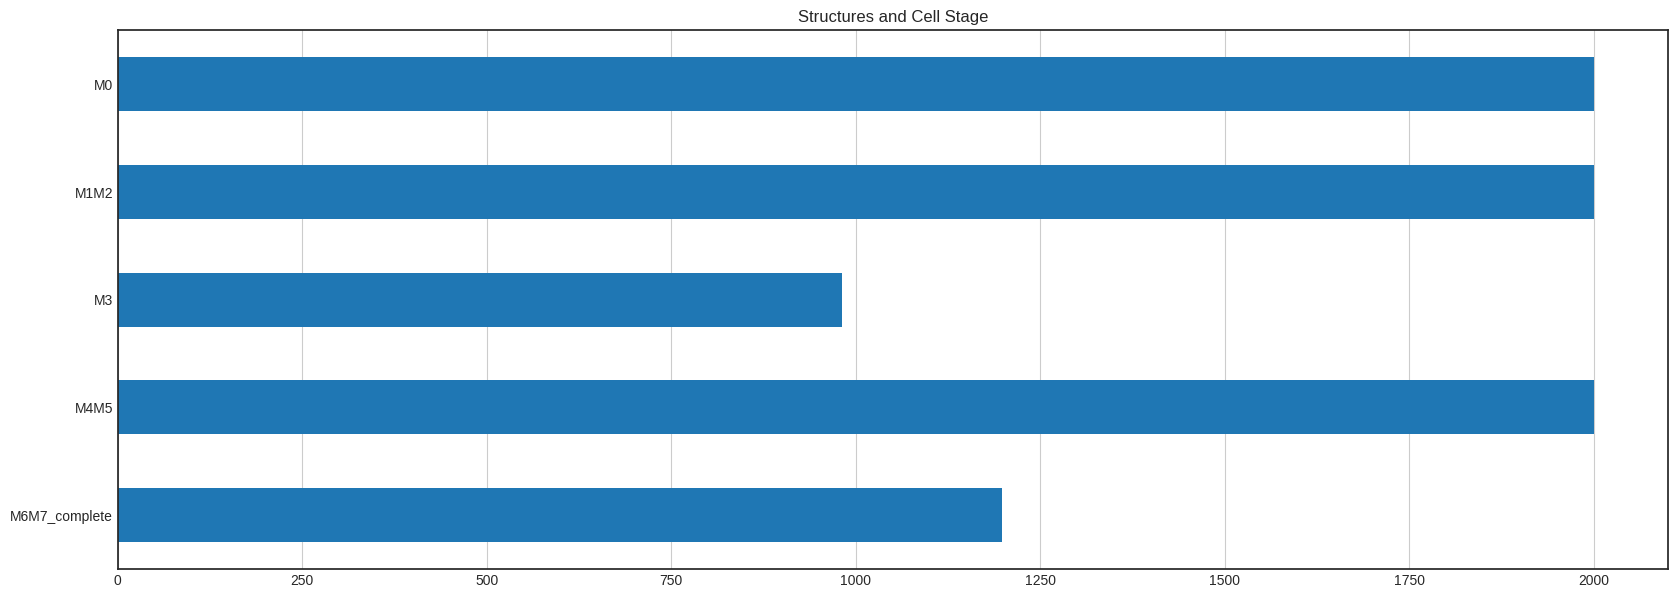

cell_stage
M0               2000
M1M2             2000
M3                981
M4M5             2000
M6M7_complete    1198
dtype: int64


In [6]:
# The bar plot again
%matplotlib inline
plt.style.use('seaborn-v0_8-white')   #print(plt.style.available)
# Code from Chapter 4 to make a bar plot
table = pd.pivot_table(df_mitocells, index="cell_stage", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Cell Stage")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()
print(table)

In [7]:
# we need the commands we type to be ran from the serotiny project root
# (because that's what `serotiny` expects) so we change directories here,
# so we can run commands within the notebook
import os
os.chdir("/home/aicsuser/eyeball_express/cytodata-hackathon-base")

In [9]:
from datetime import datetime

# util to avoid referring to the same run unintentionally
now_str = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")

In [42]:
run_name = f"keith_bf_dropout2_{now_str()}"
print(run_name)

!serotiny train \
    model=brightfield_classifier_3d \
    data=brightfield_dataloader_3d \
    mlflow.experiment_name=eyeballExpress \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=3

keith_bf_dropout2_20221020_050510
[2022-10-20 05:05:14,815][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 05:05:14,816][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 05:05:17,263][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
[2022-10-20 05:05:17,316][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: True
[2022-10-20 05:05:17,316][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 05:05:17,316][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 05:05:17,316][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2022-10-20 05:05:17,317][serotiny.ml_ops.ml_ops][INFO] - Instantiating model
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any mom

In [43]:
import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact

In [44]:
print(run_name)

keith_bf_dropout2_20221020_050510


In [45]:
!serotiny predict \
    model=brightfield_classifier_3d \
    data=brightfield_dataloader_3d \
    mlflow.experiment_name=eyeballExpress \
    mlflow.run_name={run_name} \
    trainer.gpus=[0]

[2022-10-20 05:24:02,410][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 05:24:02,411][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 05:24:04,892][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
[2022-10-20 05:24:04,926][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: True
[2022-10-20 05:24:04,926][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 05:24:04,927][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 05:24:04,927][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2022-10-20 05:24:04,927][serotiny.ml_ops.ml_ops][INFO] - Instantiating model
/opt/

In [50]:
# don't run
!serotiny predict \
    model=brightfield_classifier_3d \
    data=brightfield_dataloader_3d \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={"keith_bf_test6_20221020_013836"} \
    trainer.gpus=[0]

[2022-10-20 05:35:15,108][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 05:35:15,109][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 05:35:17,562][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
[2022-10-20 05:35:17,619][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: True
[2022-10-20 05:35:17,619][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 05:35:17,619][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 05:35:17,619][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2022-10-20 05:35:17,619][serotiny.ml_ops.ml_ops][INFO] - Instantiating model
/opt/

In [51]:
mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local")

#with download_artifact("predictions/model_predictions_multiclass.csv", experiment_name="eyeballExpress", run_name=run_name) as path:
#    predictions_3d_df = pd.read_csv(path)

with download_artifact("predictions/model_predictions_multiclass.csv", experiment_name="cytodata_chapter5", run_name="keith_bf_test6_20221020_013836") as path:
    predictions_3d_df = pd.read_csv(path)

/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:144: FutureWarning: ``mlflow.tracking.fluent.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  for _experiment in mlflow.list_experiments():
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1066: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  return MlflowClient().list_experiments(
/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:156: FutureWarning: ``mlflow.tracking.fluent.list_run_infos`` is deprecated. This method will be removed in a future release. Use ``search_runs()`` instead.
  for run_info in mlflow.list_run_infos(experiment_id=experiment_id):
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1599: FutureWarning: ``mlflow.tracking.client.MlflowClient.li

In [52]:
predictions_3d_df = predictions_3d_df.merge(df_mitocells[['CellId','split']].rename(columns={'CellId':'id'}), on = 'id')
predictions_3d_df.head()

,id,y,yhat,loss,split
0,337329,0,1,0.381658,train
1,264993,0,0,0.381658,train
2,316110,0,0,0.381658,valid
3,973484,0,1,0.381658,train
4,881280,0,0,0.381658,test


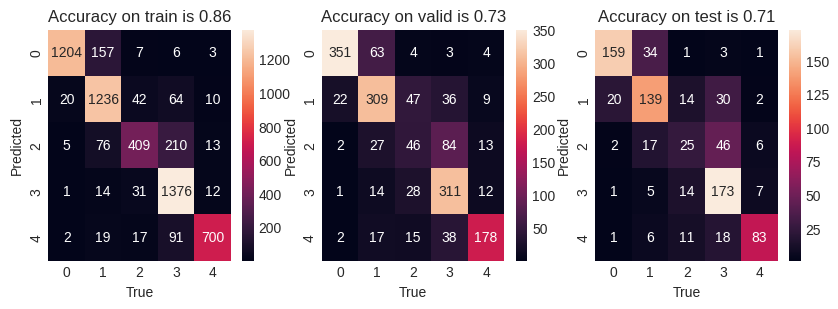

In [53]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# make confusion matrix for each split
splits = ['train','valid','test']
fig, axes = plt.subplots(nrows=1,ncols=len(splits),figsize=(10, 3), dpi=100)

for i,split in enumerate(splits):
    
    y_true = predictions_3d_df[predictions_3d_df['split']==split]['y'].to_numpy()
    y_pred = predictions_3d_df[predictions_3d_df['split']==split]['yhat'].to_numpy()
    y_pred = np.round(y_pred) #get to crisp binary class labels from posterior probability

    # Computer confusion matrix
    cm = confusion_matrix(y_true, y_pred)    
    score = accuracy_score(y_true,y_pred) #compute accuracy score
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, fmt='d',ax = axes[i])
    axes[i].set_title(f'Accuracy on {split} is {score:.2f}')
    axes[i].set_xlabel('True')
    axes[i].set_ylabel('Predicted')

plt.show()